##RAW_DATA

In [ ]:
!pip install --upgrade pip


In [ ]:
!pip install gdown

In [ ]:
import gdown
import zipfile
import os

# Step 1: Download the main ZIP file from Google Drive
file_id = '1RV2RZ743plQk2X4K36B8JkyL5ktbUxZm'
url = f'https://drive.google.com/uc?export=download&id={file_id}'
zip_path = '/content/dataset.zip'
extract_folder = '/kaggle/input/hehe32'

gdown.download(url, zip_path, quiet=False)

# Step 2: Extract the main ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Step 3: Extract each nested ZIP file
for root, _, files in os.walk(extract_folder):
    for file in files:
        if file.endswith('.zip'):
            zip_file_path = os.path.join(root, file)
            extract_subfolder = os.path.join(root, file.replace('.zip', ''))

            # Extract the nested ZIP file
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_subfolder)

            # Optionally, delete the extracted ZIP file to save space
            os.remove(zip_file_path)

print(f"All ZIP files extracted successfully to {extract_folder}")


##NEWDATA##

In [1]:
import gdown
import zipfile
import os

# Step 1: Download the main ZIP file from Google Drive
file_id = '1CIx2CdMeKQPfhpqgvnXG6pIE0x_w9DYd'
url = f'https://drive.google.com/uc?export=download&id={file_id}'
zip_path = '/kaggle/working/dataset.zip'
extract_folder = '/kaggle/working/extracted'

gdown.download(url, zip_path, quiet=False)

# Step 2: Extract the main ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Step 3: Extract each nested ZIP file
for root, _, files in os.walk(extract_folder):
    for file in files:
        if file.endswith('.zip'):
            zip_file_path = os.path.join(root, file)
            extract_subfolder = os.path.join(root, file.replace('.zip', ''))

            # Extract the nested ZIP file
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_subfolder)

            # Optionally, delete the extracted ZIP file to save space
            os.remove(zip_file_path)

print(f"All ZIP files extracted successfully to {extract_folder}")


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1CIx2CdMeKQPfhpqgvnXG6pIE0x_w9DYd
From (redirected): https://drive.google.com/uc?export=download&id=1CIx2CdMeKQPfhpqgvnXG6pIE0x_w9DYd&confirm=t&uuid=84781cb7-4f8c-430f-962f-3f99ecc10243
To: /kaggle/working/dataset.zip
100%|██████████| 2.47G/2.47G [00:23<00:00, 106MB/s] 


All ZIP files extracted successfully to /kaggle/working/extracted


#PRE_PROCESSING

In [2]:
import os

def extract_dx_from_header(header_file):
    """
    Extracts Dx codes from .hea file.
    """
    with open(header_file, "r") as f:
        for line in f:
            if line.startswith("#Dx:"):
                return line.split(": ")[1].strip().split(",")  # Extract and split codes
    return []

def save_labeled_records(dataset_path, single_label_txt, double_label_txt, multi_label_txt):
    """
    Saves the full path of ECG records based on their label count:
    - Single-label records
    - Double-label (exactly 2 labels) records
    - Multi-label (more than 2 labels) records
    """
    with open(single_label_txt, "w") as single_f, \
         open(double_label_txt, "w") as double_f, \
         open(multi_label_txt, "w") as multi_f:

        for root, _, files in os.walk(dataset_path):
            for file in files:
                if file.endswith(".hea"):
                    file_path = os.path.join(root, file)
                    dx_codes = extract_dx_from_header(file_path)

                    if len(dx_codes) == 1:
                        single_f.write(f"{file_path.replace('.hea', '')}\n")
                    elif len(dx_codes) == 2:
                        double_f.write(f"{file_path.replace('.hea', '')}\n")
                    elif len(dx_codes) > 2:
                        multi_f.write(f"{file_path.replace('.hea', '')}\n")

# Paths to dataset and output text files
dataset_path = "/kaggle/working/"
single_label_txt = "single_label_records.txt"
double_label_txt = "double_label_records.txt"
multi_label_txt = "multi_label_records.txt"

# Extract and save ECG records based on label count
save_labeled_records(dataset_path, single_label_txt, double_label_txt, multi_label_txt)

In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.io
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

def load_disease_mapping(csv_path):
    disease_df = pd.read_csv(csv_path)
    return dict(zip(disease_df['Snomed_CT'].astype(str), disease_df['Acronym Name']))

def bandpass_filter(signal, lowcut=0.4, highcut=50.0, fs=500, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def preprocess_ecg(record_path, disease_mapping, lead_indices):
    """
    Process a single ECG record for multiple leads.
    For each record, it:
      - Loads the .mat file and extracts signals for each lead in lead_indices.
      - Loads the corresponding header file to extract disease labels.
      - Applies a bandpass filter and normalization to each lead.
      - Segments each lead's signal into windows (beats) and stacks them so that each beat is
        a 2D array of shape (window_size, num_leads).
    """
    mat_path = record_path + ".mat"
    hea_path = record_path + ".hea"

    mat_data = scipy.io.loadmat(mat_path)
    # Extract signals for each desired lead
    signals = [mat_data['val'][i] for i in lead_indices]

    with open(hea_path, "r") as f:
        header_lines = f.readlines()

    disease_labels = set()
    for line in header_lines:
        if line.startswith("#Dx:"):
            dx_codes = line.split(":")[1].strip().split(",")
            mapped_diseases = {disease_mapping.get(code, "Unknown") for code in dx_codes}
            disease_labels = mapped_diseases - {"Unknown"}
            break

    if not disease_labels:
        return None, None

    # Apply bandpass filtering and normalization on each lead separately
    filtered_signals = []
    for sig in signals:
        filtered = bandpass_filter(sig)
        filtered = (filtered - np.mean(filtered)) / np.std(filtered)
        filtered_signals.append(filtered)

    # Segment the signals into beats (windows) with a 50% overlap
    window_size = 250
    beats = []
    labels = []
    # Assuming all leads have the same length; using the first lead as reference.
    for i in range(0, len(filtered_signals[0]) - window_size, window_size // 2):
        # Extract window from each lead and stack so that each beat has shape (window_size, num_leads)
        beat = np.array([fs[i:i + window_size] for fs in filtered_signals]).T
        beats.append(beat)
        labels.append(disease_labels)

    return beats, labels

def process_filtered_dataset(dataset_path, disease_csv, records_txt, unknown_txt, lead_indices):
    disease_mapping = load_disease_mapping(disease_csv)
    X, y = [], []
    unknown_records = []

    with open(records_txt, "r") as f:
        records = [line.strip() for line in f.readlines()]

    for record_name in records:
        record_path = os.path.join(dataset_path, record_name)
        print(f"Processing: {record_path}")
        try:
            beats, labels = preprocess_ecg(record_path, disease_mapping, lead_indices)
            if beats is None:
                unknown_records.append(record_path)
            else:
                X.extend(beats)
                y.extend(labels)
        except Exception as e:
            print(f"Error processing {record_name}: {e}")

    with open(unknown_txt, "w") as f:
        for record in unknown_records:
            f.write(f"{record}\n")

    print(f"\nTotal Unknown Disease Records: {len(unknown_records)} (Saved in {unknown_txt})")
    return np.array(X), y

def balance_dataset_random_over_sampling(X, y, max_samples=1000):
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y)
    print("\nOriginal Class Distribution:")
    original_counts = y_encoded.sum(axis=0)
    for disease, count in zip(mlb.classes_, original_counts):
        print(f"{disease}: {count}")

    target_count = min(int(original_counts.max()), max_samples)
    label_indices = {label_idx: np.where(y_encoded[:, label_idx] == 1)[0] for label_idx in range(len(mlb.classes_))}

    X_new, y_new = list(X), list(y)

    for label_idx, label in enumerate(mlb.classes_):
        current_count = original_counts[label_idx]
        deficit = target_count - current_count
        if deficit > 0:
            sampled_indices = np.random.choice(label_indices[label_idx], size=deficit, replace=True)
            for idx in sampled_indices:
                X_new.append(X[idx])
                y_new.append(y[idx])

    X_new = np.array(X_new)
    indices = np.arange(len(X_new))
    np.random.shuffle(indices)
    X_new = X_new[indices]
    y_new = [y_new[i] for i in indices]

    new_counts = mlb.transform(y_new).sum(axis=0)
    print("\nResampled Class Distribution:")
    for disease, count in zip(mlb.classes_, new_counts):
        print(f"{disease}: {min(count, max_samples)}")

    return X_new, y_new

# --- Main Execution ---
dataset_path = "/kaggle/working/extracted"
disease_csv = "/kaggle/input/hehe32/ConditionNames_SNOMED-CT.csv"
records_txt = "/kaggle/working/double_label_records.txt"
unknown_txt = "unknown_records_1_46_randomOS.txt"
# For multi-lead processing, use leads V1 to V6.
# In many datasets, if the order is [I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5, V6],
# then V1–V6 correspond to indices 6–11.
lead_indices = list(range(0, 12))

X, y = process_filtered_dataset(dataset_path, disease_csv, records_txt, unknown_txt, lead_indices)
X_balanced, y_balanced = balance_dataset_random_over_sampling(X, y, max_samples=2000)

# Step 4: Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Step 5: Save processed data
output_dir = f"/kaggle/working/processed_1_46_LEAD{'_'.join(['V'+str(i) for i in range(1,7)])}_SMOTE"
os.makedirs(output_dir, exist_ok=True)
np.save(os.path.join(output_dir, "X_train.npy"), X_train)
np.save(os.path.join(output_dir, "X_test.npy"), X_test)
np.save(os.path.join(output_dir, "y_train.npy"), y_train)
np.save(os.path.join(output_dir, "y_test.npy"), y_test)
print("\nFinal dataset saved! ✅")

# Zip the processed data files
import zipfile
zip_filename = os.path.join(output_dir, "processed_data.zip")
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for filename in ["X_train.npy", "X_test.npy", "y_train.npy", "y_test.npy"]:
        file_path = os.path.join(output_dir, filename)
        zipf.write(file_path, arcname=filename)

print(f"\nData successfully zipped into {zip_filename}")


##TRAINING

In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import models, layers, callbacks, regularizers
from tensorflow.keras.optimizers import Adam

# --- Step 1: Define Paths and Load Data ---
X_test_path = "/kaggle/working/processed_1_46_LEADV1_V2_V3_V4_V5_V6_SMOTE/X_test.npy"
X_train_path = "/kaggle/working/processed_1_46_LEADV1_V2_V3_V4_V5_V6_SMOTE/X_train.npy"
y_test_path = "/kaggle/working/processed_1_46_LEADV1_V2_V3_V4_V5_V6_SMOTE/y_test.npy"
y_train_path = "/kaggle/working/processed_1_46_LEADV1_V2_V3_V4_V5_V6_SMOTE/y_train.npy"

def load_numpy_file(file_path, allow_pickle=False):
    """Load a NumPy file and handle errors."""
    try:
        if os.path.exists(file_path):
            data = np.load(file_path, allow_pickle=allow_pickle)
            print(f"✅ Successfully loaded: {file_path}, Shape: {data.shape}")
            return data
        else:
            print(f"⚠️ File not found: {file_path}")
            return np.array([])
    except Exception as e:
        if not allow_pickle:
            print(f"⚠️ Retrying {file_path} with allow_pickle=True")
            try:
                data = np.load(file_path, allow_pickle=True)
                print(f"✅ Successfully loaded: {file_path}, Shape: {data.shape}")
                return data
            except Exception as e2:
                print(f"⚠️ Error loading {file_path} even with allow_pickle=True: {e2}")
                return np.array([])
        else:
            print(f"⚠️ Error loading {file_path}: {e}")
            return np.array([])

# Load data from specified paths
X_train = load_numpy_file(X_train_path)
X_test = load_numpy_file(X_test_path)
y_train = load_numpy_file(y_train_path, allow_pickle=True)
y_test = load_numpy_file(y_test_path, allow_pickle=True)

# Exit if data loading failed
if X_train.size == 0 or X_test.size == 0 or y_train.size == 0 or y_test.size == 0:
    raise FileNotFoundError("Dataset loading failed. Ensure the .npy files exist at the specified paths.")

# Flatten label arrays if needed
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

# Convert labels to strings (ensuring hashability)
if y_train.dtype.kind in 'iuf':
    y_train = np.array([f"class_{y}" for y in y_train])
else:
    y_train = np.array([str(y) for y in y_train])

if y_test.dtype.kind in 'iuf':
    y_test = np.array([f"class_{y}" for y in y_test])
else:
    y_test = np.array([str(y) for y in y_test])

print(f"Train Data Loaded: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test Data Loaded: {X_test.shape}, Labels: {y_test.shape}")
print(f"Number of unique classes in train set: {len(np.unique(y_train))}")
print(f"Number of unique classes in test set: {len(np.unique(y_test))}")

# --- Step 2: Print Class Distribution Before Balancing ---
def print_class_distribution(y, title):
    y_series = pd.Series([str(label) for label in y])
    class_counts = y_series.value_counts()
    print(f"{title} Class Distribution (showing top 20):\n", class_counts.head(20))
    plt.figure(figsize=(16, 6))
    if len(class_counts) > 50:
        top_classes = class_counts.head(50)
        sns.barplot(x=list(top_classes.index), y=top_classes.values)
        plt.title(f"{title} (Top 50 Classes)")
    else:
        sns.barplot(x=list(class_counts.index), y=class_counts.values)
        plt.title(title)
    plt.xticks(rotation=90)
    plt.xlabel("Class Labels")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

try:
    print_class_distribution(y_train, "Before Balancing - Train Set")
    print_class_distribution(y_test, "Before Balancing - Test Set")
except Exception as e:
    print(f"Error in visualization: {e}")

# --- Step 3: Balance Dataset with Median Balancing ---
def balance_dataset(X, y):
    df = pd.DataFrame({'signal': list(X), 'label': [str(label) for label in y]})
    median_count = df['label'].value_counts().median()
    def sample_group(group):
        if len(group) >= median_count:
            return group.sample(n=int(median_count), random_state=42)
        else:
            return group.sample(n=int(median_count), replace=True, random_state=42)
    df_balanced = df.groupby('label', group_keys=False).apply(sample_group)
    return np.array(df_balanced['signal'].tolist()), df_balanced['label'].values

try:
    X_train_bal, y_train_bal = balance_dataset(X_train, y_train)
    X_test_bal, y_test_bal = balance_dataset(X_test, y_test)
    try:
        print_class_distribution(y_train_bal, "After Balancing - Train Set")
        print_class_distribution(y_test_bal, "After Balancing - Test Set")
    except Exception as e:
        print(f"Error in visualization after balancing: {e}")
except Exception as e:
    print(f"Error in balancing dataset: {e}")
    print("Proceeding with original unbalanced dataset")
    X_train_bal, y_train_bal = X_train, y_train
    X_test_bal, y_test_bal = X_test, y_test

# --- Step 4: Data Preprocessing ---
def preprocess_data(X_train, X_test, y_train, y_test):
    mean, std = np.mean(X_train), np.std(X_train)
    epsilon = 1e-8  # to avoid division by zero
    X_train_norm = (X_train - mean) / (std + epsilon)
    X_test_norm = (X_test - mean) / (std + epsilon)
    if len(X_train.shape) == 2:
        X_train_norm = X_train_norm.reshape(-1, X_train.shape[1], 1)
        X_test_norm = X_test_norm.reshape(-1, X_test.shape[1], 1)
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    return X_train_norm, X_test_norm, y_train_encoded, y_test_encoded, label_encoder

# --- Step 5: Custom Layers ---
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name="attention_weight", shape=(input_shape[-1], 1),
                                 initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="attention_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)
    def call(self, x):
        e = tf.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        return tf.reduce_sum(x * a, axis=1)

def se_block(x, reduction=16):
    """
    Squeeze-and-Excitation (SE) block for 1D inputs.
    """
    filters = int(x.shape[-1])
    se = layers.GlobalAveragePooling1D()(x)
    se = layers.Dense(filters // reduction, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, filters))(se)
    return layers.multiply([x, se])

# --- Step 6: Enhanced Model with Residual, SE, and Inception-like Blocks ---
def create_enhanced_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Inception-like Block: multi-scale feature extraction
    conv1 = layers.Conv1D(32, kernel_size=3, padding="same", activation='relu')(inputs)
    conv2 = layers.Conv1D(32, kernel_size=5, padding="same", activation='relu')(inputs)
    conv3 = layers.Conv1D(32, kernel_size=7, padding="same", activation='relu')(inputs)
    merged = layers.Concatenate()([conv1, conv2, conv3])
    merged = layers.BatchNormalization()(merged)

    def residual_block(x, filters):
        shortcut = x
        x = layers.Conv1D(filters, 3, padding='same', activation='relu',
                          kernel_regularizer=regularizers.l2(0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv1D(filters, 3, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
        x = layers.BatchNormalization()(x)
        if int(shortcut.shape[-1]) != filters:
            shortcut = layers.Conv1D(filters, 1, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        x = layers.Add()([shortcut, x])
        return layers.Activation('relu')(x)

    # Stack residual blocks with SE blocks
    x = residual_block(merged, 64)
    x = se_block(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = residual_block(x, 128)
    x = se_block(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = residual_block(x, 256)
    x = se_block(x)

    # Global pooling for feature aggregation
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers with dropout for classification
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)

# --- Step 7: Custom Callback to Stop Training within a Certain Accuracy Range ---
class AccuracyRangeStopping(callbacks.Callback):
    def __init__(self, min_accuracy=0.75, max_accuracy=0.80):
        super(AccuracyRangeStopping, self).__init__()
        self.min_accuracy = min_accuracy
        self.max_accuracy = max_accuracy
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if accuracy is not None and val_accuracy is not None:
            if self.min_accuracy <= accuracy <= self.max_accuracy or self.min_accuracy <= val_accuracy <= self.max_accuracy:
                print(f"\nTraining stopped as accuracy or validation accuracy is within the range [{self.min_accuracy}, {self.max_accuracy}].")
                self.model.stop_training = True

# --- Step 8: Train Model ---
def train_model(X_train, X_test, y_train, y_test):
    X_train_processed, X_test_processed, y_train_encoded, y_test_encoded, label_encoder = preprocess_data(X_train, X_test, y_train, y_test)
    print(f"Processed train shape: {X_train_processed.shape}")
    print(f"Number of classes: {len(label_encoder.classes_)}")

    model = create_enhanced_model(input_shape=X_train_processed.shape[1:], num_classes=len(label_encoder.classes_))

    # Use a lower learning rate and add gradient clipping
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    model.summary()

    # Calculate class weights for handling imbalance
    class_weights = dict(enumerate(compute_class_weight("balanced",
                                                        classes=np.unique(y_train_encoded),
                                                        y=y_train_encoded)))

    # Define callbacks (without TerminateOnNaN)
    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
    model_checkpoint = callbacks.ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True)
    accuracy_range_stopping = AccuracyRangeStopping(min_accuracy=0.75, max_accuracy=0.80)

    # Adjust batch size based on dataset size
    batch_size = 128
    if len(y_train_encoded) > 500000:
        batch_size = 256
    elif len(y_train_encoded) < 50000:
        batch_size = 64
    print(f"Training with batch size: {batch_size}")

    history = model.fit(
        X_train_processed, y_train_encoded,
        epochs=50,
        batch_size=batch_size,
        validation_data=(X_test_processed, y_test_encoded),
        class_weight=class_weights,
        callbacks=[early_stopping, reduce_lr, model_checkpoint, accuracy_range_stopping]
    )

    return model, history, label_encoder

# --- Step 9: Model Training, Evaluation, and Saving ---
if X_train_bal.size and X_test_bal.size:
    print("Starting model training...")
    try:
        model, history, label_encoder = train_model(X_train_bal, X_test_bal, y_train_bal, y_test_bal)
        model.save("lead6_CNN_enhanced_double.h5")
        print("Model saved successfully!")
        with open('lead6_CNN_enhanced_double.pkl', 'wb') as f:
            pickle.dump(label_encoder.classes_, f)
        print("Labels saved as lead6_CNN_enhanced_double.pkl")

        # Evaluate the model
        y_pred = model.predict(X_test_bal)
        y_pred_classes = np.argmax(y_pred, axis=1)
        print("Classification Report:")
        print(classification_report(y_test_bal, y_pred_classes, target_names=label_encoder.classes_))

        # Plot confusion matrix
        conf_matrix = confusion_matrix(y_test_bal, y_pred_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error during model training: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Failed to balance dataset. Check data loading.")


##NEW 10_03_2025

##prepre

In [30]:
import os
import numpy as np
import pandas as pd
import scipy.io
from scipy.signal import butter, filtfilt, medfilt, stft, find_peaks
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import zipfile
import pywt

def load_disease_mapping(csv_path):
    disease_df = pd.read_csv(csv_path)
    return dict(zip(disease_df['Snomed_CT'].astype(str), disease_df['Acronym Name']))

def bandpass_filter(signal, lowcut=0.4, highcut=50.0, fs=500, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def adaptive_wavelet_denoise(signal, wavelet='db4', level=1):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    denoised_coeffs = coeffs[:]
    denoised_coeffs[1:] = [pywt.threshold(c, value=uthresh, mode='soft') for c in denoised_coeffs[1:]]
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signal[:len(signal)]

def baseline_correction(signal, kernel_size=201):
    baseline = medfilt(signal, kernel_size=kernel_size)
    return signal - baseline

def detect_qrs(signal, fs=500):
    # Simple QRS detection using find_peaks on the signal
    distance = int(0.2 * fs)  # minimum 200ms between peaks
    prominence = np.std(signal) * 0.5
    peaks, _ = find_peaks(signal, distance=distance, prominence=prominence)
    return peaks

def compute_stft(beat, fs=500):
    # Computes the STFT for the beat (assumes beat shape: (window_size, num_leads))
    stft_list = []
    for i in range(beat.shape[1]):
        f, t, Zxx = stft(beat[:, i], fs=fs, nperseg=50)
        stft_list.append(np.abs(Zxx))
    # Output shape: (num_leads, freq_bins, time_bins)
    stft_array = np.array(stft_list)
    return stft_array

def augment_beat(beat, noise_level=0.005):
    # Adds slight Gaussian noise to the beat
    noise = np.random.normal(0, noise_level, beat.shape)
    return beat + noise

def preprocess_ecg(record_path, disease_mapping, lead_indices, fs=500, use_stft=False, augment=False):
    mat_path = record_path + ".mat"
    hea_path = record_path + ".hea"
    mat_data = scipy.io.loadmat(mat_path)
    
    # Process the specified lead (only one lead in this case)
    signals = []
    for lead_index in lead_indices:
        raw_signal = mat_data['val'][lead_index]
        # 1. Bandpass filtering
        filtered_signal = bandpass_filter(raw_signal, fs=fs)
        # 2. Adaptive denoising using wavelet transform
        denoised_signal = adaptive_wavelet_denoise(filtered_signal)
        # 3. Baseline correction
        corrected_signal = baseline_correction(denoised_signal)
        # 4. Z-score normalization
        normalized_signal = (corrected_signal - np.mean(corrected_signal)) / np.std(corrected_signal)
        signals.append(normalized_signal)
    
    # Combined signal will now be of shape (1, signal_length)
    combined_signal = np.vstack(signals)
    
    # Read header to get disease labels
    with open(hea_path, "r") as f:
        header_lines = f.readlines()
    
    disease_labels = set()
    for line in header_lines:
        if line.startswith("#Dx:"):
            dx_codes = line.split(":")[1].strip().split(",")
            mapped_diseases = {disease_mapping.get(code, "Unknown") for code in dx_codes}
            disease_labels = mapped_diseases - {"Unknown"}
            break
    
    if not disease_labels:
        return None, None
    
    # Dynamic segmentation: detect QRS complexes on the selected lead (only one lead)
    qrs_indices = detect_qrs(signals[0], fs=fs)
    beats = []
    labels = []
    pre_samples = 50
    post_samples = 200  # Total window size = 250 samples
    
    for r_idx in qrs_indices:
        if r_idx - pre_samples < 0 or r_idx + post_samples > combined_signal.shape[1]:
            continue
        # Extract beat: shape becomes (window_size, num_leads=1)
        beat = combined_signal[:, r_idx - pre_samples : r_idx + post_samples].T
        # Optional augmentation
        if augment:
            beat = augment_beat(beat)
        # Optionally convert beat to a time-frequency representation
        if use_stft:
            beat = compute_stft(beat, fs=fs)
        beats.append(beat)
        labels.append(disease_labels)
    
    return beats, labels

def process_filtered_dataset(dataset_path, disease_csv, records_txt, unknown_txt, lead_indices, fs=500, use_stft=False, augment=False):
    disease_mapping = load_disease_mapping(disease_csv)
    X, y = [], []
    unknown_records = []
    
    with open(records_txt, "r") as f:
        records = [line.strip() for line in f.readlines()]
    
    for record_name in records:
        record_path = os.path.join(dataset_path, record_name)
        print(f"Processing: {record_path}")
        try:
            beats, labels = preprocess_ecg(record_path, disease_mapping, lead_indices, fs=fs, use_stft=use_stft, augment=augment)
            if beats is None:
                unknown_records.append(record_path)
            else:
                X.extend(beats)
                y.extend(labels)
        except Exception as e:
            print(f"Error processing {record_name}: {e}")
    
    with open(unknown_txt, "w") as f:
        for record in unknown_records:
            f.write(f"{record}\n")
    
    print(f"\nTotal Unknown Disease Records: {len(unknown_records)} (Saved in {unknown_txt})")
    return np.array(X, dtype=object), y

def balance_dataset_random_over_sampling(X, y, max_samples=10000):
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y)
    print("\nOriginal Class Distribution:")
    original_counts = y_encoded.sum(axis=0)
    for disease, count in zip(mlb.classes_, original_counts):
        print(f"{disease}: {count}")
    
    target_count = min(int(original_counts.max()), max_samples)
    label_indices = {label_idx: np.where(y_encoded[:, label_idx] == 1)[0] for label_idx in range(len(mlb.classes_))}
    
    X_new, y_new = list(X), list(y)
    
    for label_idx, label in enumerate(mlb.classes_):
        current_count = original_counts[label_idx]
        deficit = target_count - current_count
        if deficit > 0:
            sampled_indices = np.random.choice(label_indices[label_idx], size=deficit, replace=True)
            for idx in sampled_indices:
                X_new.append(X[idx])
                y_new.append(y[idx])
    
    X_new = np.array(X_new, dtype=object)
    indices = np.arange(len(X_new))
    np.random.shuffle(indices)
    X_new = X_new[indices]
    y_new = [y_new[i] for i in indices]
    
    new_counts = mlb.transform(y_new).sum(axis=0)
    print("\nResampled Class Distribution:")
    for disease, count in zip(mlb.classes_, new_counts):
        print(f"{disease}: {min(count, max_samples)}")
    
    return X_new, y_new

# --- Main Execution ---
dataset_path = "/kaggle/working/extracted"
disease_csv = "/kaggle/input/hehe32/ConditionNames_SNOMED-CT.csv"
records_txt = "/kaggle/working/double_label_records.txt"
unknown_txt = "unknown_records_1_46_NewStrategy.txt"
lead_indices = (11,)  

# Set additional parameters for the new preprocessing strategy
use_stft = True      # Transform each beat to a time-frequency representation
augment = True       # Apply data augmentation to each beat
fs = 500             # Sampling frequency

X, y = process_filtered_dataset(dataset_path, disease_csv, records_txt, unknown_txt, lead_indices, fs=fs, use_stft=use_stft, augment=augment)
X_balanced, y_balanced = balance_dataset_random_over_sampling(X, y, max_samples=10000)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Save processed data
output_dir = f"/kaggle/working/processed_1_46_LEAD{'_'.join(map(str, lead_indices))}_NewStrategy"
os.makedirs(output_dir, exist_ok=True)
np.save(os.path.join(output_dir, "X_train.npy"), X_train)
np.save(os.path.join(output_dir, "X_test.npy"), X_test)
np.save(os.path.join(output_dir, "y_train.npy"), y_train)
np.save(os.path.join(output_dir, "y_test.npy"), y_test)
print("\nFinal dataset saved! ✅")

# Zip the processed data files
zip_filename = os.path.join(output_dir, "processed_data.zip")
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for filename in ["X_train.npy", "X_test.npy", "y_train.npy", "y_test.npy"]:
        file_path = os.path.join(output_dir, filename)
        zipf.write(file_path, arcname=filename)

print(f"\nData successfully zipped into {zip_filename}")


Processing: /kaggle/working/extracted/37/371/JS36533
Processing: /kaggle/working/extracted/37/371/JS36544
Processing: /kaggle/working/extracted/37/371/JS36556
Processing: /kaggle/working/extracted/37/371/JS36583
Processing: /kaggle/working/extracted/37/371/JS36507
Processing: /kaggle/working/extracted/37/371/JS36575
Processing: /kaggle/working/extracted/37/371/JS36595
Processing: /kaggle/working/extracted/37/371/JS36532
Processing: /kaggle/working/extracted/37/371/JS36518
Processing: /kaggle/working/extracted/37/371/JS36513
Processing: /kaggle/working/extracted/37/371/JS36592
Processing: /kaggle/working/extracted/37/371/JS36573
Processing: /kaggle/working/extracted/37/373/JS36784
Processing: /kaggle/working/extracted/37/373/JS36736
Processing: /kaggle/working/extracted/37/373/JS36794
Processing: /kaggle/working/extracted/37/373/JS36746
Processing: /kaggle/working/extracted/37/373/JS36741
Processing: /kaggle/working/extracted/37/373/JS36743
Processing: /kaggle/working/extracted/37/373/J

/usr/local/lib/python3.10/dist-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)


Processing: /kaggle/working/extracted/37/376/JS37083
Processing: /kaggle/working/extracted/37/376/JS37089
Processing: /kaggle/working/extracted/37/374/JS36806
Processing: /kaggle/working/extracted/37/374/JS36887
Processing: /kaggle/working/extracted/37/374/JS36847
Processing: /kaggle/working/extracted/37/374/JS36809
Processing: /kaggle/working/extracted/37/374/JS36899
Processing: /kaggle/working/extracted/37/374/JS36827
Processing: /kaggle/working/extracted/37/374/JS36888
Processing: /kaggle/working/extracted/37/374/JS36886
Processing: /kaggle/working/extracted/37/374/JS36815
Processing: /kaggle/working/extracted/37/374/JS36885
Processing: /kaggle/working/extracted/37/374/JS36836
Processing: /kaggle/working/extracted/37/379/JS37356
Processing: /kaggle/working/extracted/37/379/JS37345
Processing: /kaggle/working/extracted/37/379/JS37372
Processing: /kaggle/working/extracted/37/379/JS37328
Processing: /kaggle/working/extracted/37/379/JS37312
Processing: /kaggle/working/extracted/37/379/J

⚠️ Retrying /kaggle/working/processed_1_46_LEAD11_NewStrategy/X_train.npy with allow_pickle=True
✅ Successfully loaded: /kaggle/working/processed_1_46_LEAD11_NewStrategy/X_train.npy, Shape: (451671, 1, 26, 11)
⚠️ Retrying /kaggle/working/processed_1_46_LEAD11_NewStrategy/X_test.npy with allow_pickle=True
✅ Successfully loaded: /kaggle/working/processed_1_46_LEAD11_NewStrategy/X_test.npy, Shape: (112918, 1, 26, 11)
✅ Successfully loaded: /kaggle/working/processed_1_46_LEAD11_NewStrategy/y_train.npy, Shape: (451671,)
✅ Successfully loaded: /kaggle/working/processed_1_46_LEAD11_NewStrategy/y_test.npy, Shape: (112918,)
Train Data Loaded: (451671, 1, 26, 11), Labels: (451671,)
Test Data Loaded: (112918, 1, 26, 11), Labels: (112918,)
Number of unique classes in train set: 220
Number of unique classes in test set: 220
Before Balancing - Train Set Class Distribution (showing top 20):
 {'SB'}             26927
{'AF'}             26799
{'ST'}             16767
{'SB', 'TWC'}      12153
{'AF', 'TW

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


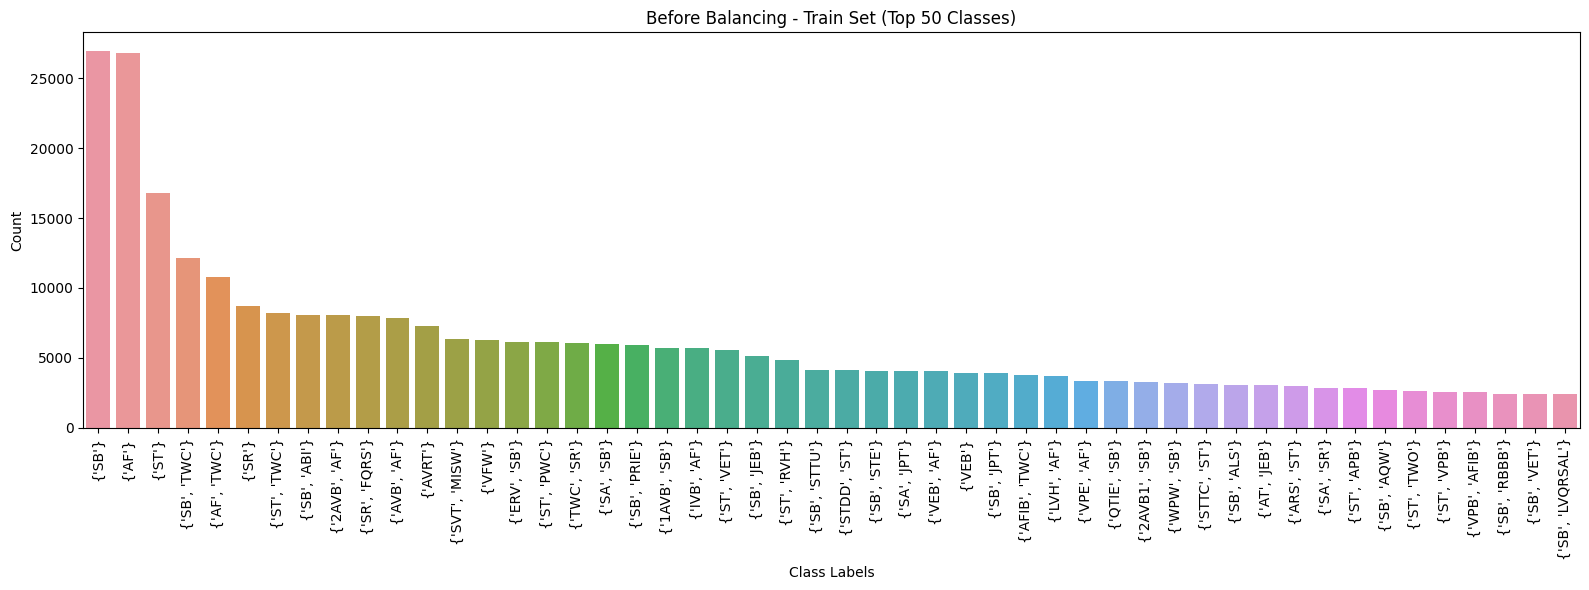

Before Balancing - Test Set Class Distribution (showing top 20):
 {'AF'}             6900
{'SB'}             6622
{'ST'}             4282
{'SB', 'TWC'}      3058
{'AF', 'TWC'}      2636
{'SR'}             2140
{'ST', 'TWC'}      2117
{'SR', 'FQRS'}     1992
{'2AVB', 'AF'}     1945
{'SB', 'ABI'}      1936
{'AVB', 'AF'}      1888
{'AVRT'}           1761
{'SVT', 'MISW'}    1601
{'ERV', 'SB'}      1579
{'VFW'}            1573
{'ST', 'PWC'}      1519
{'TWC', 'SR'}      1514
{'SB', 'PRIE'}     1497
{'1AVB', 'SB'}     1469
{'SA', 'SB'}       1439
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


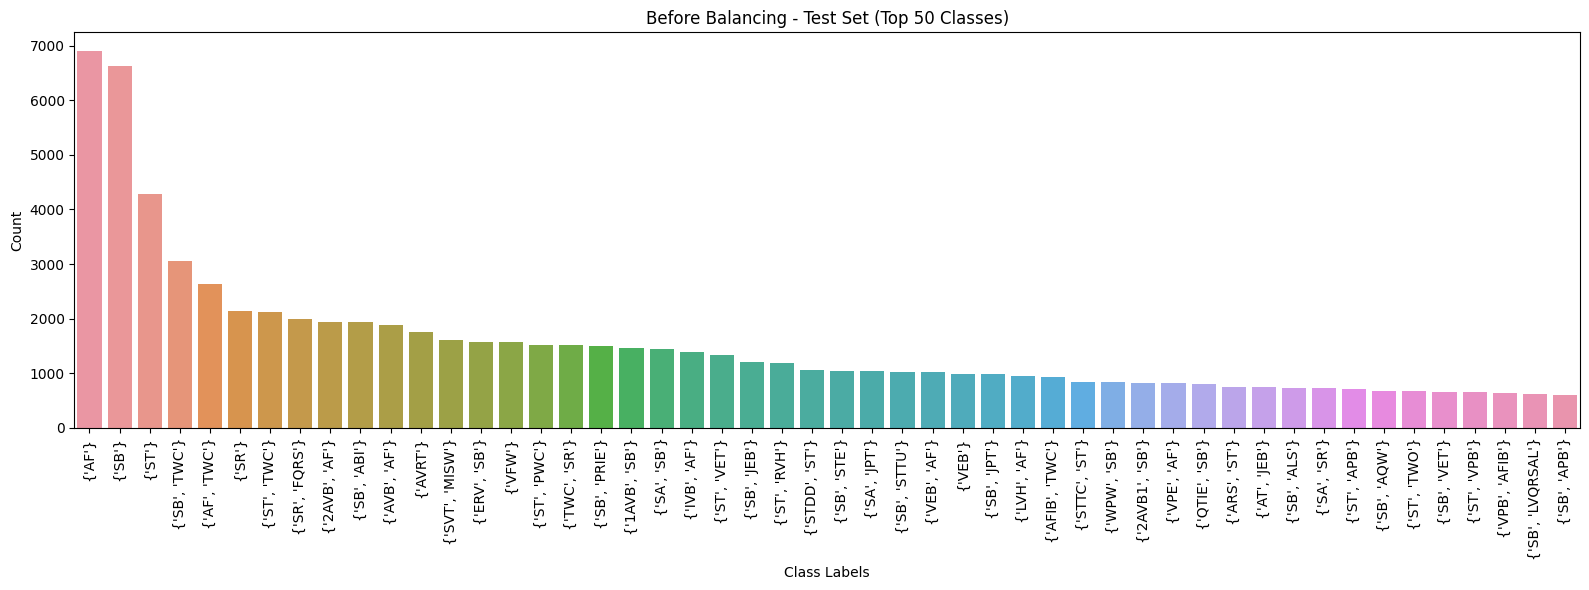

<ipython-input-32-621444e7af87>:115: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label', group_keys=False).apply(sample_group)
<ipython-input-32-621444e7af87>:115: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label', group_keys=False).apply(sample_group)


After Balancing - Train Set Class Distribution (showing top 20):
 {'WPW', 'SVT'}     1031
{'1AVB', 'SA'}     1031
{'1AVB', 'SB'}     1031
{'1AVB', 'SR'}     1031
{'VFW', '1AVB'}    1031
{'VFW', 'SVT'}     1031
{'VFW'}            1031
{'VPB', 'AF'}      1031
{'VPB', 'AFIB'}    1031
{'VPB', 'SR'}      1031
{'VPB', 'SVT'}     1031
{'VPE', 'AF'}      1031
{'AF', 'SR'}       1031
{'AF', 'STE'}      1031
{'AF', 'STTU'}     1031
{'AF', 'SVT'}      1031
{'AF', 'TWC'}      1031
{'AF', 'TWO'}      1031
{'AF', 'UW'}       1031
{'AF'}             1031
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


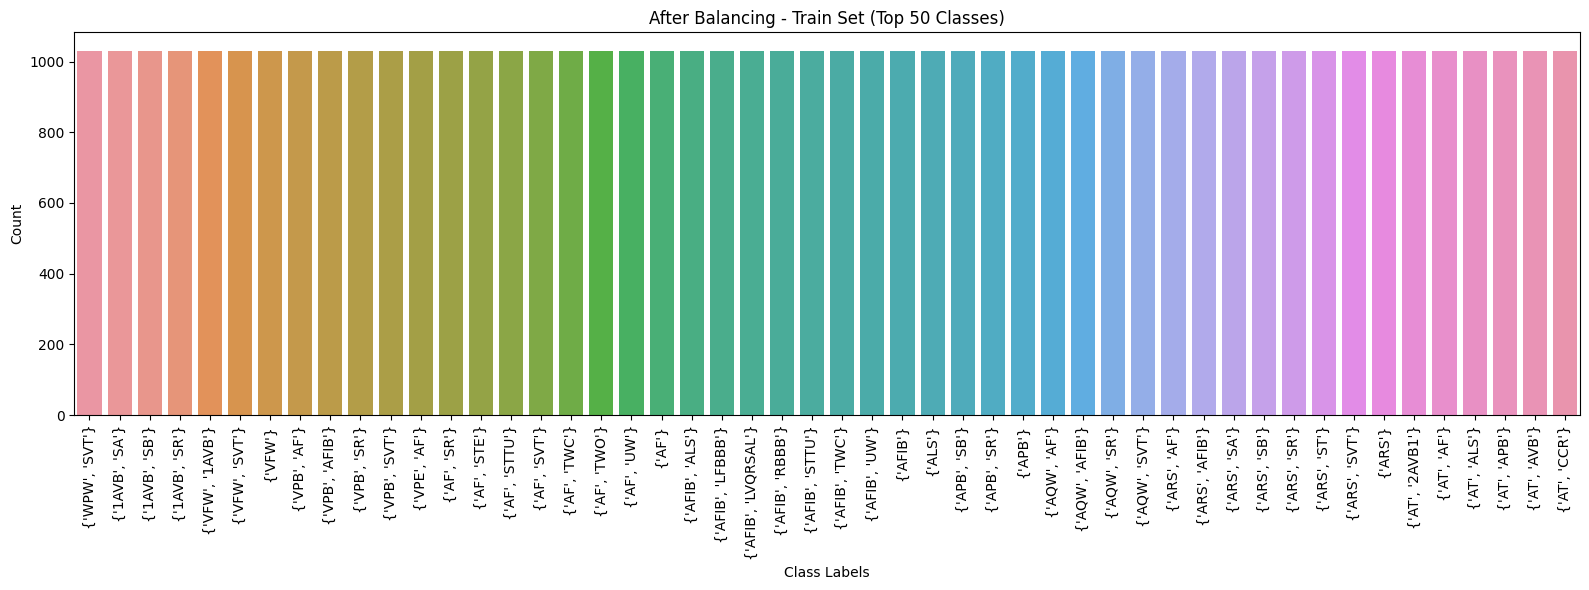

After Balancing - Test Set Class Distribution (showing top 20):
 {'WPW', 'SVT'}     258
{'1AVB', 'SA'}     258
{'1AVB', 'SB'}     258
{'1AVB', 'SR'}     258
{'VFW', '1AVB'}    258
{'VFW', 'SVT'}     258
{'VFW'}            258
{'VPB', 'AF'}      258
{'VPB', 'AFIB'}    258
{'VPB', 'SR'}      258
{'VPB', 'SVT'}     258
{'VPE', 'AF'}      258
{'AF', 'SR'}       258
{'AF', 'STE'}      258
{'AF', 'STTU'}     258
{'AF', 'SVT'}      258
{'AF', 'TWC'}      258
{'AF', 'TWO'}      258
{'AF', 'UW'}       258
{'AF'}             258
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


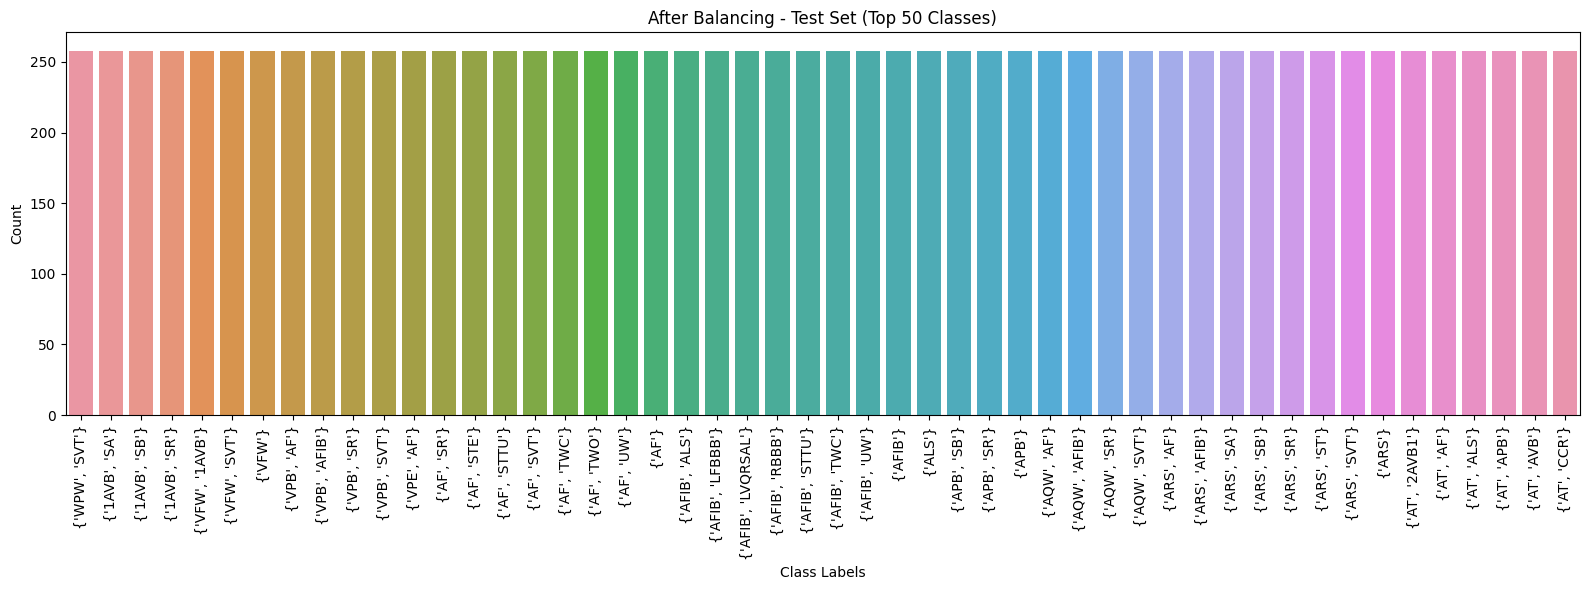

Starting model training...
Processed train shape: (226820, 26, 11)
Number of classes: 220


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 26, 11)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_71 (Conv1D)        │ (None, 26, 64)         │          4,992 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_109   │ (None, 26, 64)         │            256 │ conv1d_71[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_14          │ (None, 13, 64)         │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_72 (Conv1D)        │ (None, 13, 64)         │         12,352 │ max_pooling1d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_110   │ (None, 13, 64)         │            256 │ conv1d_72[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_73 (Conv1D)        │ (None, 13, 64)         │         12,352 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_111   │ (None, 13, 64)         │            256 │ conv1d_73[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_27 (Add)              │ (None, 13, 64)         │              0 │ max_pooling1d_14[0][0… │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_27             │ (None, 13, 64)         │              0 │ add_27[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_74 (Conv1D)        │ (None, 13, 128)        │         24,704 │ activation_27[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_112   │ (None, 13, 128)        │            512 │ conv1d_74[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_76 (Conv1D)        │ (None, 13, 128)        │          8,320 │ activation_27[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_75 (Conv1D)        │ (None, 13, 128)        │         49,280 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_114   │ (None, 13, 128)        │            512 │ conv1d_76[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 1,956,578 (7.46 MB)

 Trainable params: 1,951,586 (7.44 MB)

 Non-trainable params: 4,992 (19.50 KB)

Training with batch size: 128
Epoch 1/50
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 56s 26ms/step - accuracy: 0.1589 - loss: 5.8265 - val_accuracy: 0.3414 - val_loss: 3.5461 - learning_rate: 0.0020
Epoch 2/50
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.4024 - loss: 3.2750 - val_accuracy: 0.4490 - val_loss: 3.0202 - learning_rate: 0.0020
Epoch 3/50
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.4656 - loss: 3.0241 - val_accuracy: 0.4837 - val_loss: 2.8071 - learning_rate: 0.0020
Epoch 4/50
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.5177 - loss: 2.7372 - val_accuracy: 0.4171 - val_loss: 3.3255 - learning_rate: 0.0020
Epoch 5/50
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - accuracy: 0.4469 - loss: 3.3253 - val_accuracy: 0.5315 - val_loss: 2.6223 - learning_rate: 0.0020
Epoch 6/50
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.5387 - loss: 2.6421 - val_accuracy: 0.5116 - val_loss: 2.8163 - learning_rate: 0.0020
Epoch 7/50
1773/1773 ━━━━━━━━━━━━━

Traceback (most recent call last):
  File "<ipython-input-32-621444e7af87>", line 284, in <cell line: 269>
    y_pred = model.predict(X_test_bal)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/constant_op.py", line 108, in convert_to_eager_tensor
    return ops.EagerTensor(value, ctx.device_name, dtype)
ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).


In [32]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import models, layers, callbacks, regularizers
from tensorflow.keras.optimizers import Adam

# --- Step 1: Define Paths and Load Data ---
X_test_path = "/kaggle/working/processed_1_46_LEAD11_NewStrategy/X_test.npy"
X_train_path = "/kaggle/working/processed_1_46_LEAD11_NewStrategy/X_train.npy"
y_test_path = "/kaggle/working/processed_1_46_LEAD11_NewStrategy/y_test.npy"
y_train_path = "/kaggle/working/processed_1_46_LEAD11_NewStrategy/y_train.npy"

def load_numpy_file(file_path, allow_pickle=False):
    """Load a NumPy file and handle errors."""
    try:
        if os.path.exists(file_path):
            data = np.load(file_path, allow_pickle=allow_pickle)
            print(f"✅ Successfully loaded: {file_path}, Shape: {data.shape}")
            return data
        else:
            print(f"⚠️ File not found: {file_path}")
            return np.array([])
    except Exception as e:
        # If initial load fails, try with allow_pickle=True
        if not allow_pickle:
            print(f"⚠️ Retrying {file_path} with allow_pickle=True")
            try:
                data = np.load(file_path, allow_pickle=True)
                print(f"✅ Successfully loaded: {file_path}, Shape: {data.shape}")
                return data
            except Exception as e2:
                print(f"⚠️ Error loading {file_path} even with allow_pickle=True: {e2}")
                return np.array([])
        else:
            print(f"⚠️ Error loading {file_path}: {e}")
            return np.array([])

# Load data from specified paths
X_train = load_numpy_file(X_train_path)
X_test = load_numpy_file(X_test_path)
y_train = load_numpy_file(y_train_path, allow_pickle=True)  # Use allow_pickle for labels
y_test = load_numpy_file(y_test_path, allow_pickle=True)    # Use allow_pickle for labels

# Exit if data loading failed
if X_train.size == 0 or X_test.size == 0 or y_train.size == 0 or y_test.size == 0:
    raise FileNotFoundError("Dataset loading failed. Ensure the .npy files exist at the specified paths.")

# Ensure y_train and y_test are 1D arrays if they aren't already
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

# Convert labels to string for consistent handling
if y_train.dtype.kind in 'iuf':  # If numeric
    y_train = np.array([f"class_{y}" for y in y_train])
else:
    y_train = np.array([str(y) for y in y_train])

if y_test.dtype.kind in 'iuf':  # If numeric
    y_test = np.array([f"class_{y}" for y in y_test])
else:
    y_test = np.array([str(y) for y in y_test])

print(f"Train Data Loaded: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test Data Loaded: {X_test.shape}, Labels: {y_test.shape}")
print(f"Number of unique classes in train set: {len(np.unique(y_train))}")
print(f"Number of unique classes in test set: {len(np.unique(y_test))}")

# --- Step 2: Print Class Distribution Before Balancing ---
def print_class_distribution(y, title):
    y_series = pd.Series([str(label) for label in y])
    class_counts = y_series.value_counts()

    print(f"{title} Class Distribution (showing top 20):\n", class_counts.head(20))
    plt.figure(figsize=(16, 6))
    if len(class_counts) > 50:
        top_classes = class_counts.head(50)
        sns.barplot(x=list(top_classes.index), y=top_classes.values)
        plt.title(f"{title} (Top 50 Classes)")
    else:
        sns.barplot(x=list(class_counts.index), y=class_counts.values)
        plt.title(title)
    plt.xticks(rotation=90)
    plt.xlabel("Class Labels")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

try:
    print_class_distribution(y_train, "Before Balancing - Train Set")
    print_class_distribution(y_test, "Before Balancing - Test Set")
except Exception as e:
    print(f"Error in visualization: {e}")
    print("Continuing with model building without visualization...")

# --- Step 3: Balance Dataset with Median Balancing ---
def balance_dataset(X, y):
    df = pd.DataFrame({'signal': list(X), 'label': [str(label) for label in y]})
    median_count = df['label'].value_counts().median()

    def sample_group(group):
        if len(group) >= median_count:
            return group.sample(n=int(median_count), random_state=42)
        else:
            return group.sample(n=int(median_count), replace=True, random_state=42)

    df_balanced = df.groupby('label', group_keys=False).apply(sample_group)
    return np.array(df_balanced['signal'].tolist()), df_balanced['label'].values

try:
    X_train_bal, y_train_bal = balance_dataset(X_train, y_train)
    X_test_bal, y_test_bal = balance_dataset(X_test, y_test)

    try:
        print_class_distribution(y_train_bal, "After Balancing - Train Set")
        print_class_distribution(y_test_bal, "After Balancing - Test Set")
    except Exception as e:
        print(f"Error in visualization after balancing: {e}")
        print("Continuing with model building without visualization...")
except Exception as e:
    print(f"Error in balancing dataset: {e}")
    print("Proceeding with original unbalanced dataset")
    X_train_bal, y_train_bal = X_train, y_train
    X_test_bal, y_test_bal = X_test, y_test

# --- Step 5: Data Preprocessing ---
def preprocess_data(X_train, X_test, y_train, y_test):
    # Normalize data
    mean, std = np.mean(X_train), np.std(X_train)
    X_train_norm = (X_train - mean) / std
    X_test_norm = (X_test - mean) / std

    # Remove extra dimension if it exists (expected shape: (batch, 1, sequence, features))
    if len(X_train_norm.shape) == 4 and X_train_norm.shape[1] == 1:
        X_train_norm = np.squeeze(X_train_norm, axis=1)
    if len(X_test_norm.shape) == 4 and X_test_norm.shape[1] == 1:
        X_test_norm = np.squeeze(X_test_norm, axis=1)

    # Reshape data for CNN input if needed (if data is 2D)
    if len(X_train_norm.shape) == 2:
        X_train_norm = X_train_norm.reshape(-1, X_train_norm.shape[1], 1)
        X_test_norm = X_test_norm.reshape(-1, X_test_norm.shape[1], 1)
        
    # Ensure that the data type is float32 so TensorFlow can convert it properly
    X_train_norm = np.array(X_train_norm, dtype=np.float32)
    X_test_norm = np.array(X_test_norm, dtype=np.float32)

    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    return X_train_norm, X_test_norm, y_train_encoded, y_test_encoded, label_encoder

# --- Step 6: Custom Attention Layer ---
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="attention_weight", shape=(input_shape[-1], 1),
                                 initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="attention_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        return tf.reduce_sum(x * a, axis=1)

# --- Step 7: Enhanced Model with Residual and LSTM Attention ---
def create_enhanced_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=7, padding="same", activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    def residual_block(x, filters):
        shortcut = x
        x = layers.Conv1D(filters, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv1D(filters, 3, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
        x = layers.BatchNormalization()(x)

        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv1D(filters, 1, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.Add()([shortcut, x])
        return layers.Activation('relu')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 128)
    x = residual_block(x, 256)
    x = layers.MaxPooling1D(pool_size=2)(x)

    cnn_branch = layers.GlobalAveragePooling1D()(
        layers.BatchNormalization()(layers.Conv1D(256, 3, activation="relu", padding="same")(x))
    )
    lstm_branch = AttentionLayer()(
        layers.BatchNormalization()(
            layers.Bidirectional(
                layers.LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.001))
            )(x)
        )
    )

    merged = layers.Concatenate()([cnn_branch, lstm_branch])
    merged = layers.Dropout(0.5)(
        layers.BatchNormalization()(layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(merged))
    )
    merged = layers.Dropout(0.3)(
        layers.BatchNormalization()(layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01))(merged))
    )

    return models.Model(inputs, layers.Dense(num_classes, activation="softmax")(merged))

# --- Step 8: Train Model ---
def train_model(X_train, X_test, y_train, y_test):
    X_train_processed, X_test_processed, y_train_encoded, y_test_encoded, label_encoder = preprocess_data(X_train, X_test, y_train, y_test)

    print(f"Processed train shape: {X_train_processed.shape}")
    print(f"Number of classes: {len(label_encoder.classes_)}")

    model = create_enhanced_model(input_shape=X_train_processed.shape[1:], num_classes=len(label_encoder.classes_))
    model.compile(optimizer=Adam(learning_rate=0.002), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    # Print model summary
    model.summary()

    # Calculate class weights
    class_weights = dict(enumerate(compute_class_weight("balanced", classes=np.unique(y_train_encoded), y=y_train_encoded)))

    # Define callbacks (custom callback removed)
    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
    model_checkpoint = callbacks.ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True)

    # Set batch size based on data size
    batch_size = 128
    if len(y_train_encoded) > 500000:
        batch_size = 256  # Larger batch for very large datasets
    elif len(y_train_encoded) < 50000:
        batch_size = 64  # Smaller batch for smaller datasets

    print(f"Training with batch size: {batch_size}")

    history = model.fit(
        X_train_processed, y_train_encoded,
        epochs=50,
        batch_size=batch_size,
        validation_data=(X_test_processed, y_test_encoded),
        class_weight=class_weights,
        callbacks=[early_stopping, reduce_lr, model_checkpoint]
    )

    return model, history, label_encoder

# Train only if data is available
if X_train_bal.size and X_test_bal.size:
    print("Starting model training...")
    try:
        model, history, label_encoder = train_model(X_train_bal, X_test_bal, y_train_bal, y_test_bal)

        # Save the model
        model.save("lead11_CNN_enhanced_double.h5")
        print("Model saved successfully!")

        # Save labels as .pkl
        with open('lead11_CNN_enhanced_double.pkl', 'wb') as f:
            pickle.dump(label_encoder.classes_, f)
        print("Labels saved as labels.pkl")

        # Evaluate the model
        y_pred = model.predict(X_test_bal)
        y_pred_classes = np.argmax(y_pred, axis=1)

        print("Classification Report:")
        print(classification_report(y_test_bal, y_pred_classes, target_names=label_encoder.classes_))

        # Plot confusion matrix
        conf_matrix = confusion_matrix(y_test_bal, y_pred_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error during model training: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Failed to balance dataset. Check data loading.")


#TESTINGG

✅ Model Loaded from: /kaggle/working/lead5_CNN_enhanced_double.h5
Model input shape: (None, 26, 11)
✅ Label Encoder Classes Array Loaded: ["{'1AVB', 'SA'}" "{'1AVB', 'SB'}" "{'1AVB', 'SR'}" "{'1AVB', 'ST'}"
 "{'1AVB'}" "{'2AVB', 'AF'}" "{'2AVB1', 'SA'}" "{'2AVB1', 'SB'}"
 "{'2AVB1'}" "{'AF', 'ALS'}" "{'AF', 'LFBBB'}" "{'AF', 'LVQRSAL'}"
 "{'AF', 'RBBB'}" "{'AF', 'SR'}" "{'AF', 'STE'}" "{'AF', 'STTU'}"
 "{'AF', 'SVT'}" "{'AF', 'TWC'}" "{'AF', 'TWO'}" "{'AF', 'UW'}" "{'AF'}"
 "{'AFIB', 'ALS'}" "{'AFIB', 'LFBBB'}" "{'AFIB', 'LVQRSAL'}"
 "{'AFIB', 'RBBB'}" "{'AFIB', 'STTU'}" "{'AFIB', 'TWC'}" "{'AFIB', 'UW'}"
 "{'AFIB'}" "{'ALS'}" "{'APB', 'SB'}" "{'APB', 'SR'}" "{'APB'}"
 "{'AQW', 'AF'}" "{'AQW', 'AFIB'}" "{'AQW', 'SR'}" "{'AQW', 'SVT'}"
 "{'ARS', 'AF'}" "{'ARS', 'AFIB'}" "{'ARS', 'SA'}" "{'ARS', 'SB'}"
 "{'ARS', 'SR'}" "{'ARS', 'ST'}" "{'ARS', 'SVT'}" "{'ARS'}"
 "{'AT', '2AVB1'}" "{'AT', 'AF'}" "{'AT', 'ALS'}" "{'AT', 'APB'}"
 "{'AT', 'AVB'}" "{'AT', 'CCR'}" "{'AT', 'IVB'}" "{'AT', 'JEB'

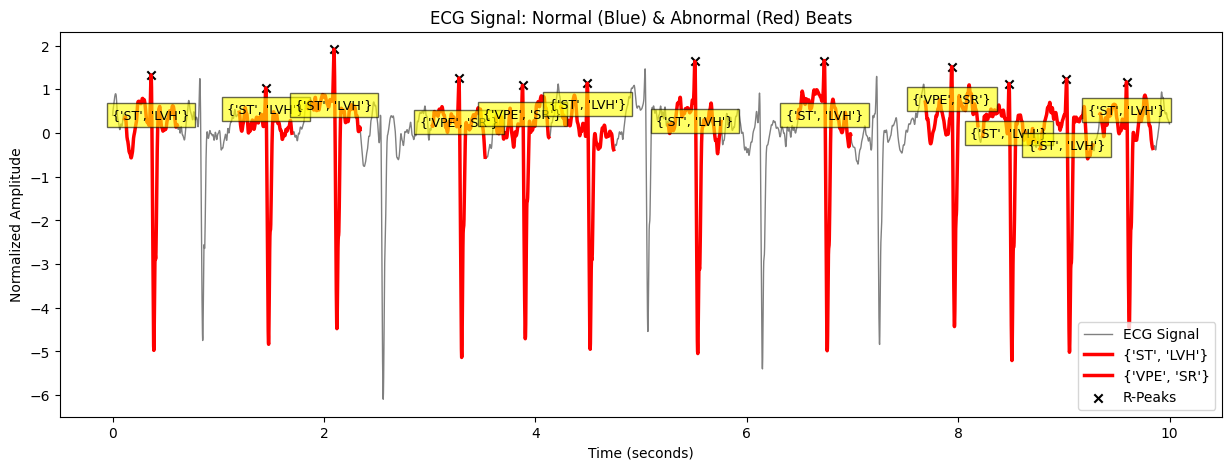


🔹 Predicted Disease Distribution:
{'ST', 'LVH'}: 9
{'VPE', 'SR'}: 3


In [19]:
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from scipy.signal import butter, filtfilt, find_peaks, resample
import pywt

# --- Custom Attention Layer Definition ---
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="attention_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="random_normal",
                                 trainable=True)
        self.b = self.add_weight(name="attention_bias",
                                 shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        weighted = x * a
        return tf.reduce_sum(weighted, axis=1)

# --- Load Trained Model ---
model_path = "/kaggle/working/lead5_CNN_enhanced_double.h5"  # Updated model path
model = tf.keras.models.load_model(model_path, custom_objects={'AttentionLayer': AttentionLayer})
print(f"✅ Model Loaded from: {model_path}")
print("Model input shape:", model.input_shape)  # Verify expected input shape

# --- Bandpass Filter ---
def bandpass_filter(signal, lowcut=0.4, highcut=50.0, fs=500, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# --- Adaptive Wavelet Denoising ---
def adaptive_wavelet_denoise(signal, wavelet='db4', level=1):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    denoised_coeffs = coeffs[:]
    denoised_coeffs[1:] = [pywt.threshold(c, value=uthresh, mode='soft') for c in denoised_coeffs[1:]]
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signal[:len(signal)]

# --- Load ECG Data ---
def load_ecg(record_path, lead_index=0):
    mat_file = record_path + ".mat"
    mat_data = scipy.io.loadmat(mat_file)
    signal = mat_data['val'][lead_index]
    return signal, 500  # Default sampling frequency = 500 Hz

# --- Detect R-Peaks ---
def detect_r_peaks(ecg_signal, fs):
    threshold = np.mean(ecg_signal) + np.std(ecg_signal)
    peaks, _ = find_peaks(ecg_signal, height=threshold, distance=fs//2)
    return peaks

# --- Preprocess ECG Signal ---
def preprocess_ecg(record_path, lead_index=0):
    signal, fs = load_ecg(record_path, lead_index)
    
    # 1. Bandpass filtering
    filtered_signal = bandpass_filter(signal, lowcut=0.4, highcut=50.0, fs=fs)
    
    # 2. Wavelet denoising
    denoised_signal = adaptive_wavelet_denoise(filtered_signal)
    
    # 3. Normalization (and conversion to float32 as in training)
    normalized_signal = (denoised_signal - np.mean(denoised_signal)) / np.std(denoised_signal)
    normalized_signal = normalized_signal.astype(np.float32)
    
    # 4. Detect R-peaks
    r_peaks = detect_r_peaks(normalized_signal, fs)
    
    return normalized_signal, fs, r_peaks

# --- Segment ECG Based on R-Peaks ---
def segment_ecg_by_r_peaks(ecg_signal, r_peaks, window_size=250):
    segments, indices = [], []
    for peak in r_peaks:
        start = max(0, peak - window_size // 2)
        end = start + window_size
        if end <= len(ecg_signal):
            segments.append(ecg_signal[start:end])
            indices.append((start, end))
    segments = np.array(segments, dtype=np.float32)
    return segments, indices

# --- Load Label Encoder ---
with open("/kaggle/working/lead5_CNN_enhanced_double.pkl", "rb") as f:  # Updated label encoder path
    label_encoder = pickle.load(f)

if hasattr(label_encoder, "classes_"):
    classes = label_encoder.classes_
    print(f"✅ Label Encoder Loaded: {classes}")
else:
    classes = label_encoder
    print(f"✅ Label Encoder Classes Array Loaded: {classes}")

# --- Detect & Visualize Abnormal Beats ---
def detect_and_plot_abnormalities(record_path, lead_index=0, window_size=250, normal_label="SR"):
    # Preprocess ECG signal
    ecg_signal, fs, r_peaks = preprocess_ecg(record_path, lead_index)

    # Segment ECG using detected R-peaks
    segments, seg_indices = segment_ecg_by_r_peaks(ecg_signal, r_peaks, window_size=window_size)
    if len(segments) == 0:
        print("⚠️ No valid segments extracted!")
        return
    print("Shape of segments:", segments.shape)  # Diagnostic: should be (num_segments, 250)

    # --- Resample Each Segment to Match Model Input ---
    # The model expects input shape (None, 26, 11), so total samples = 26 * 11 = 286
    target_length = 26 * 11  # 286 samples
    resampled_segments = []
    for seg in segments:
        resampled_seg = resample(seg, target_length)
        resampled_seg = resampled_seg.reshape(26, 11)
        resampled_segments.append(resampled_seg)
    resampled_segments = np.array(resampled_segments, dtype=np.float32)
    print("Shape of resampled_segments:", resampled_segments.shape)  # Diagnostic: should be (num_segments, 26, 11)

    # Predict using resampled_segments
    predictions = model.predict(resampled_segments, verbose=0)
    pred_classes = np.argmax(predictions, axis=1)

    # Convert class indices to labels
    try:
        pred_labels = label_encoder.inverse_transform(pred_classes)
    except AttributeError:
        pred_labels = np.array([classes[idx] for idx in pred_classes])

    # --- Plot Full ECG Signal ---
    plt.figure(figsize=(15, 5))
    time_axis = np.arange(len(ecg_signal)) / fs  # Convert samples to seconds
    plt.plot(time_axis, ecg_signal, color="gray", linewidth=1, label="ECG Signal")

    # Overlay segmented beats with color coding (blue for normal, red for abnormal)
    for (start_idx, end_idx), disease in zip(seg_indices, pred_labels):
        color = "blue" if disease == normal_label else "red"
        time_range = np.arange(start_idx, end_idx) / fs
        plt.plot(time_range, ecg_signal[start_idx:end_idx], color=color, linewidth=2.5,
                 label=disease if disease not in plt.gca().get_legend_handles_labels()[1] else "")
        # Add label at segment midpoint
        r_peak_time = (start_idx + end_idx) / (2 * fs)
        plt.text(r_peak_time, ecg_signal[start_idx], disease,
                 fontsize=9, color="black", ha="center",
                 bbox=dict(facecolor="yellow", alpha=0.6, edgecolor="black"))

    # Overlay detected R-peaks
    plt.scatter(r_peaks / fs, ecg_signal[r_peaks], color="black", marker="x", label="R-Peaks")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Normalized Amplitude")
    plt.title("ECG Signal: Normal (Blue) & Abnormal (Red) Beats")
    plt.legend()
    plt.show()

    # Print prediction distribution
    unique_labels, counts = np.unique(pred_labels, return_counts=True)
    print("\n🔹 Predicted Disease Distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"{label}: {count}")

# --- Main Execution ---
dataset_path = "/kaggle/working/extracted/03/039"
record_name = "JS03052"
record_path = os.path.join(dataset_path, record_name)

detect_and_plot_abnormalities(record_path, lead_index=6, window_size=250, normal_label="SR")